In [1]:
import os
import pickle
import re
import time
from datetime import date, datetime

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from pandas.api.types import CategoricalDtype

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

## Scrape WNBA 2024 Season Data

In [2]:
snapshot_url = 'https://www.basketball-reference.com/wnba/years/2024_games.html'
headers = {'User-Agent': 'Mozilla/5.0'}
snapshot_response = requests.get(snapshot_url, headers=headers)
status_code = snapshot_response.status_code  
print(status_code)

200


In [3]:
wnba_soup = BeautifulSoup(snapshot_response.content, "html.parser")

In [4]:
print(wnba_soup.prettify()[100000:104000])

eam_name">
          <a href="/wnba/teams/MIN/2024.html">
           Minnesota Lynx
          </a>
         </td>
         <td class="right" data-stat="home_pts">
          84
         </td>
         <td class="center" data-stat="box_score_text">
          <a href="/wnba/boxscores/202405250MIN.html">
           Box Score
          </a>
         </td>
         <td class="left iz" data-stat="notes">
         </td>
        </tr>
        <tr>
         <th class="left" csk="202405250PHO" data-stat="date_game" scope="row">
          Sat, May 25, 2024
         </th>
         <td class="left" csk="DAL.202405250PHO" data-stat="visitor_team_name">
          <a href="/wnba/teams/DAL/2024.html">
           Dallas Wings
          </a>
         </td>
         <td class="right" data-stat="visitor_pts">
          107
         </td>
         <td class="left" csk="PHO.202405250PHO" data-stat="home_team_name">
          <a href="/wnba/teams/PHO/2024.html">
           Phoenix Mercury
          </a>
      

In [5]:
date_vals = wnba_soup.find_all('th', {'data-stat': 'date_game'})[1:]
dates = [date_val.get_text(strip=True) for date_val in date_vals]

In [6]:
visitor_vals = wnba_soup.find_all('td', {'data-stat': 'visitor_team_name'})
visitors = [visitor_val.get_text(strip=True) for visitor_val in visitor_vals]

In [7]:
visitor_pt_vals = wnba_soup.find_all('td', {'data-stat': 'visitor_pts'})
visitor_pts = [visitor_pt_val.get_text(strip=True) for visitor_pt_val in visitor_pt_vals]

In [8]:
home_vals = wnba_soup.find_all('td', {'data-stat': 'home_team_name'})
homes = [home_val.get_text(strip=True) for home_val in home_vals]

In [9]:
home_pt_vals = wnba_soup.find_all('td', {'data-stat': 'home_pts'})
home_pts = [home_pt_val.get_text(strip=True) for home_pt_val in home_pt_vals]

In [10]:
len(dates), len(visitors), len(visitor_pts), len(homes), len(home_pts)

(240, 240, 240, 240, 240)

In [11]:
days = [date.split(', ', 1)[0] for date in dates]
dates = [datetime.strptime(date.split(', ', 1)[1], '%b %d, %Y').date() for date in dates]

In [12]:
schedule = pd.DataFrame(list(zip(days, dates, homes, visitors, home_pts, visitor_pts)),
              columns=['Day', 'Date', 'HomeTeam', 'AwayTeam', 'HomePts', 'AwayPts'])

In [13]:
schedule.head(5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79


In [14]:
specified_date = datetime.strptime('2024-07-05', '%Y-%m-%d').date() # Halfway through WNBA season

In [15]:
current_schedule = schedule[schedule['Date'] < specified_date]
current_schedule.head(-5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79
...,...,...,...,...,...,...
107,Sun,2024-06-30,Phoenix Mercury,Indiana Fever,82,88
108,Mon,2024-07-01,Phoenix Mercury,Connecticut Sun,72,83
109,Mon,2024-07-01,Seattle Storm,Dallas Wings,95,71
110,Tue,2024-07-02,Atlanta Dream,Chicago Sky,77,85


In [16]:
current_schedule.loc[:, 'HomePts'] = current_schedule['HomePts'].astype(int)
current_schedule.loc[:, 'AwayPts'] = current_schedule['AwayPts'].astype(int)

In [17]:
current_schedule.loc[:, 'PtsDiff'] = current_schedule.loc[:, 'HomePts'] - current_schedule.loc[:, 'AwayPts']
current_schedule.loc[:, 'HomeWin'] = (current_schedule.loc[:, 'PtsDiff'] > 0).astype(int)
current_schedule.loc[:, 'AtHome'] = 1
current_schedule.head(5)

/var/folders/y4/y0p80v6n18s2f__pscpp8y300000gn/T/ipykernel_30830/3902425747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_schedule.loc[:, 'PtsDiff'] = current_schedule.loc[:, 'HomePts'] - current_schedule.loc[:, 'AwayPts']
/var/folders/y4/y0p80v6n18s2f__pscpp8y300000gn/T/ipykernel_30830/3902425747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_schedule.loc[:, 'HomeWin'] = (current_schedule.loc[:, 'PtsDiff'] > 0).astype(int)
/var/folders/y4/y0p80v6n18s2f__pscpp8y300000gn/T/ipykerne

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts,PtsDiff,HomeWin,AtHome
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71,21,1,1
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80,9,1,1
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83,-13,0,1
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85,-5,0,1
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79,8,1,1


In [18]:
current_schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 0 to 116
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Day       117 non-null    object
 1   Date      117 non-null    object
 2   HomeTeam  117 non-null    object
 3   AwayTeam  117 non-null    object
 4   HomePts   117 non-null    object
 5   AwayPts   117 non-null    object
 6   PtsDiff   117 non-null    object
 7   HomeWin   117 non-null    int64 
 8   AtHome    117 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 9.1+ KB


In [19]:
current_schedule.shape

(117, 9)

In [20]:
current_schedule.to_csv('completed_games_wnba_2024.csv', index=False)
schedule.to_csv('all_games_wnba_2024.csv', index=False)

In [21]:
schedule

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79
...,...,...,...,...,...,...
235,Thu,2024-09-19,Las Vegas Aces,Dallas Wings,,
236,Thu,2024-09-19,Minnesota Lynx,Los Angeles Sparks,,
237,Thu,2024-09-19,New York Liberty,Atlanta Dream,,
238,Thu,2024-09-19,Phoenix Mercury,Seattle Storm,,


## EDA -- TODO

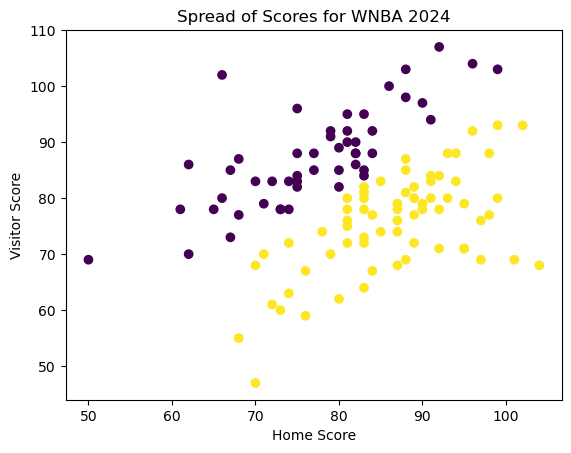

In [22]:
plt.scatter(current_schedule['HomePts'], current_schedule['AwayPts'], c=current_schedule['HomeWin']);
plt.title("Spread of Scores for WNBA 2024");
plt.xlabel("Home Score");
plt.ylabel("Visitor Score");

# Predictions from R code

## Team Strengths Prediction (Normal Model) (no home field advantage)

In [89]:
normal_estimates = pd.read_csv("normal_estimates_wnba2024.csv")

In [91]:
normal_estimates.rename(columns={normal_estimates.columns[0]: "Team", normal_estimates.columns[1]: "Est"}, inplace = True)
normal_estimates.sort_values(by=['Est'])
normal_estimates

,Team,Est,StdErr
0,Minnesota Lynx,8.003111,2.142083
1,New York Liberty,7.827851,2.135670
2,Seattle Storm,5.691924,2.192034
3,Connecticut Sun,5.225962,2.121156
4,Las Vegas Aces,4.720595,2.244608
5,HFA,1.113765,0.967844
6,Phoenix Mercury,-1.067878,2.138708
7,Chicago Sky,-2.519935,2.248822
8,Washington Mystics,-3.946555,2.074456
9,Atlanta Dream,-4.419343,2.246607


## Team Strengths Prediction (Thurstone-Mosteller Model)

In [92]:
tm_estimates = pd.read_csv("thurstone_estimates_wnba2024.csv")

In [93]:
tm_estimates.rename(columns={tm_estimates.columns[0]: "Team" }, inplace = True)
tm_estimates.sort_values(by=['Est'])
tm_estimates

,Team,Est,StdErr
0,New York Liberty,1.011260,0.344251
1,Connecticut Sun,0.824364,0.323247
2,Minnesota Lynx,0.671567,0.300594
3,Seattle Storm,0.571845,0.311114
4,Las Vegas Aces,0.408647,0.303965
5,HFA,0.170442,0.138878
6,Phoenix Mercury,0.108711,0.291483
7,Indiana Fever,-0.238940,0.288386
8,Atlanta Dream,-0.316216,0.307078
9,Chicago Sky,-0.402796,0.301194


## Team Strengths Prediction (Bradley-Terry Model)

In [94]:
bt_estimates = pd.read_csv("bt_estimates_wnba2024.csv")

In [95]:
bt_estimates.rename(columns={bt_estimates.columns[0]: "Team" }, inplace = True)

In [96]:
bt_estimates.sort_values(by=['Est'], ascending=False)

,Team,Est,Stderr
8,New York Liberty,1.785830,0.627957
0,Connecticut Sun,1.398259,0.569215
7,Minnesota Lynx,1.169655,0.519484
2,Seattle Storm,0.939498,0.535052
1,Las Vegas Aces,0.709572,0.519382
12,HFA,0.298806,0.242281
9,Phoenix Mercury,0.223910,0.506832
6,Indiana Fever,-0.355800,0.497629
10,Atlanta Dream,-0.568010,0.531498
11,Chicago Sky,-0.750814,0.515445


## Number of Wins Prediction (Bradley-Terry Model)

In [97]:
num_wins_estimates = pd.read_csv("wnba_win_number_preds.csv")

In [98]:
num_wins_estimates.rename(columns={num_wins_estimates.columns[0]: "Team", num_wins_estimates.columns[1]: "NumWins"}, inplace = True)
num_wins_estimates

,Team,NumWins
0,New York Liberty,33.824785
1,Connecticut Sun,30.184287
2,Minnesota Lynx,27.605937
3,Seattle Storm,26.797481
4,Las Vegas Aces,25.014588
5,Phoenix Mercury,21.077557
6,Indiana Fever,18.220174
7,Chicago Sky,17.346997
8,Atlanta Dream,12.150983
9,Washington Mystics,9.652730


## Further Analysis Using Team Strength Estimates

### Bradley-Terry estimates compared to Thurstone-Mosteller estimates

In [110]:
all_model_ests = pd.concat([normal_estimates.set_index('Team'),bt_estimates.set_index('Team'), tm_estimates.set_index('Team')], axis=1, join='inner')
all_model_ests.columns.values[0] = "NEst"
all_model_ests.columns.values[2] = "TMEst"
all_model_ests.columns.values[4] = "BTEst"
all_model_ests

,NEst,StdErr,TMEst,Stderr,BTEst,StdErr
Team,,,,,,
Minnesota Lynx,8.003111,2.142083,1.169655,0.519484,0.671567,0.300594
New York Liberty,7.827851,2.135670,1.785830,0.627957,1.011260,0.344251
Seattle Storm,5.691924,2.192034,0.939498,0.535052,0.571845,0.311114
Connecticut Sun,5.225962,2.121156,1.398259,0.569215,0.824364,0.323247
Las Vegas Aces,4.720595,2.244608,0.709572,0.519382,0.408647,0.303965
HFA,1.113765,0.967844,0.298806,0.242281,0.170442,0.138878
Phoenix Mercury,-1.067878,2.138708,0.223910,0.506832,0.108711,0.291483
Chicago Sky,-2.519935,2.248822,-0.750814,0.515445,-0.402796,0.301194
Washington Mystics,-3.946555,2.074456,-1.385350,0.544886,-0.832291,0.313237


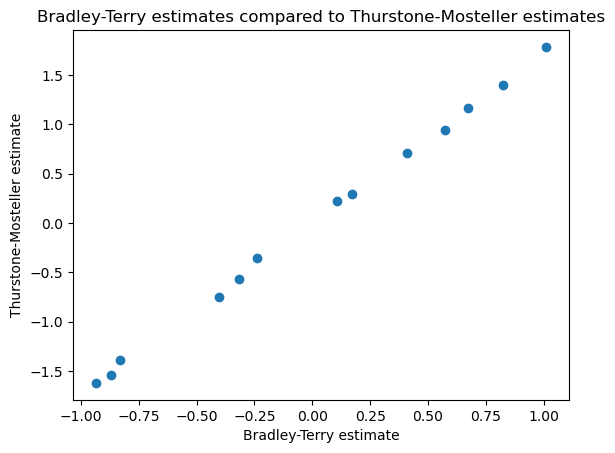

In [117]:
plt.scatter(all_model_ests['BTEst'], all_model_ests['TMEst']);
plt.title("Bradley-Terry estimates compared to Thurstone-Mosteller estimates");
plt.ylabel("Thurstone-Mosteller estimate");
plt.xlabel("Bradley-Terry estimate");

The estimates from the Bradley-Terry and Thurstone-Mosteller models are nearly in a straight y=x line, indicating that they agree with the ordering and estimated team strengths for each team.

### With 95% confidence, is there evidence whether the Chicago Sky is a better or worse team than the Indiana Fever?

TO DO

In [124]:
# Create 95% confidence interval (Thurstone-Mosteller)
std_err_fever = tm_estimates.loc[tm_estimates['Team'] == 'Indiana Fever', 'StdErr']
std_err_sky = tm_estimates.loc[tm_estimates['Team'] == 'Chicago Sky', 'StdErr']
